In [35]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
import xgboost
import shap

In [37]:
dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
features = pd.read_csv('/content/drive/MyDrive/big_5/big_5_features.csv')

In [38]:
dataset.head(2)

,user_id,post_text,Экстраверсия,Доброжелательность,Сознательность,Нейротизм,Открытость опыту,Экстраверсия_3,Доброжелательность_3,Сознательность_3,Нейротизм_3,Открытость опыту_3,Экстраверсия_5,Доброжелательность_5,Сознательность_5,Нейротизм_5,Открытость опыту_5,post_text_preprocessed
0,133,Открытое образование - Главная страница,4.88,4.11,4.67,1.13,4.9,2,2,2,0,2,4,3,4,0,4,открытое образование PUNK главная страница
1,133,Первый день форума «Бережливое управление 2.0»,4.88,4.11,4.67,1.13,4.9,2,2,2,0,2,4,3,4,0,4,первый день форума PUNK бережливое управление ...


In [39]:
features.head(2)

,adjs,advs,punkts,prons_1,prons_2,prons_3,nums,urls,conjunct,discourse,...,tense_past,tense_pres,mood_indc,mood_impr,aspect_perf,aspect_impf,emoji,hashtags,length,max_depth
0,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
1,2,0,3,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,6,3


In [40]:
def get_train_test(dataset, features, PREDICT_COLUMN):
  df = features.copy()

  df[PREDICT_COLUMN] = dataset[PREDICT_COLUMN]
  df['stratify'] = dataset[f'{PREDICT_COLUMN}_5']
  df['post_text_preprocessed'] = dataset['post_text_preprocessed']

  df = df.query('length > 10')
  #df = df.drop_duplicates(subset = "post_text_preprocessed") # это казалось хорошей идеей но скор сильно падает

  X_train, X_test, y_train, y_test = train_test_split(df, df[PREDICT_COLUMN], test_size=0.3, random_state=42, stratify=df['stratify'])

  X_train = X_train.drop(columns=[PREDICT_COLUMN, 'stratify', 'post_text_preprocessed'])
  X_test = X_test.drop(columns=[PREDICT_COLUMN, 'stratify', 'post_text_preprocessed'])

  return X_train, X_test, y_train, y_test

In [41]:
PREDICT_COLUMN = 'Экстраверсия'
X_train, X_test, y_train, y_test = get_train_test(dataset, features, PREDICT_COLUMN)
X_train.shape, X_test.shape

((50302, 21), (21558, 21))

In [42]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.11937828028042907

In [43]:
X = pd.concat([X_train,X_test])
predictions = model.predict(X)

In [44]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


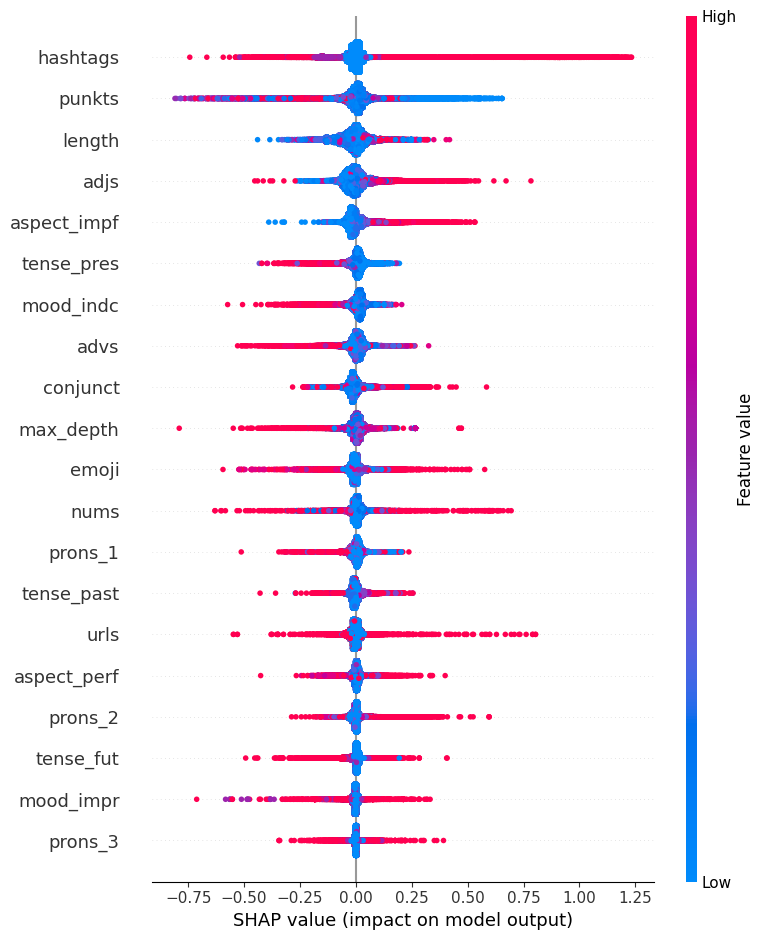

In [45]:
shap.summary_plot(shap_values, X)

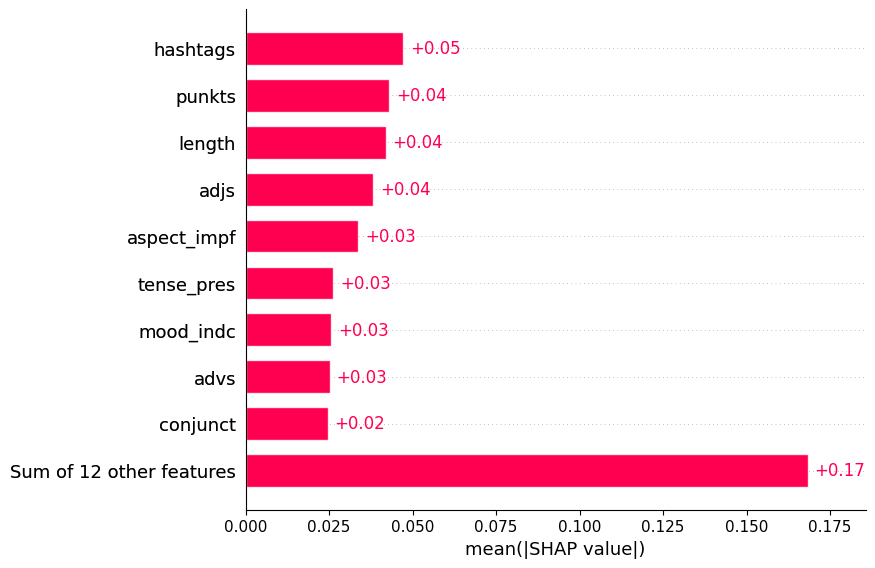

In [46]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(shap_values)

In [47]:
#for i,p in enumerate(predictions):
#  if p > 4.9 or p < 2:
#    print(i,p)

In [48]:
predictions[17599]
# Выраженный интроверт

1.9203887

In [49]:
dataset.iloc[17599]

user_id                                                                 224
post_text                                 Приветик!да нормалёк!а ты как?)))
Экстраверсия                                                            2.0
Доброжелательность                                                     3.11
Сознательность                                                         3.89
Нейротизм                                                              4.25
Открытость опыту                                                        2.8
Экстраверсия_3                                                            0
Доброжелательность_3                                                      0
Сознательность_3                                                          2
Нейротизм_3                                                               2
Открытость опыту_3                                                        0
Экстраверсия_5                                                            1
Доброжелател

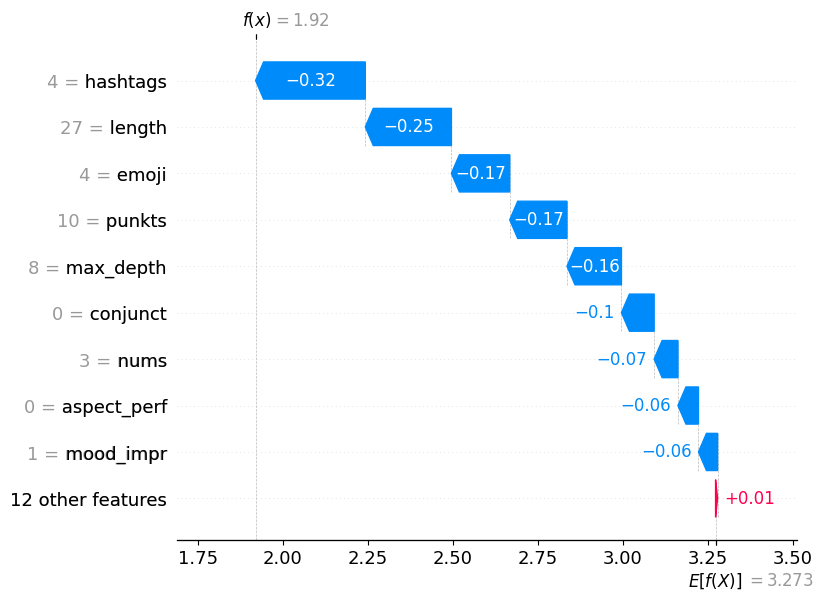

In [50]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[17599])

In [51]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[17599])

In [52]:
predictions[9742] 
# Выраженный экстраверт

4.9489837

In [53]:
dataset.iloc[9742]

user_id                                                                 178
post_text                               Да я знаю)но вот так получилось...)
Экстраверсия                                                           3.88
Доброжелательность                                                     3.33
Сознательность                                                         3.67
Нейротизм                                                              2.63
Открытость опыту                                                        4.8
Экстраверсия_3                                                            2
Доброжелательность_3                                                      1
Сознательность_3                                                          1
Нейротизм_3                                                               0
Открытость опыту_3                                                        2
Экстраверсия_5                                                            3
Доброжелател

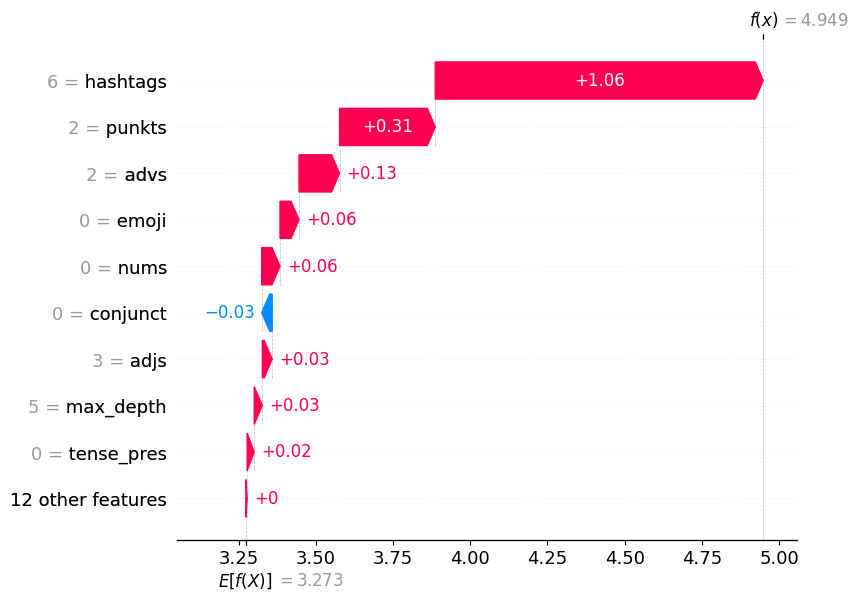

In [54]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[9742])

In [55]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[9742])

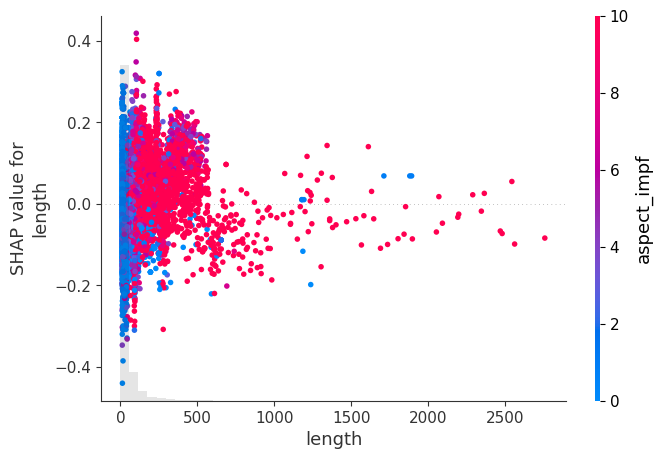

In [56]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"length"], color=shap_values)

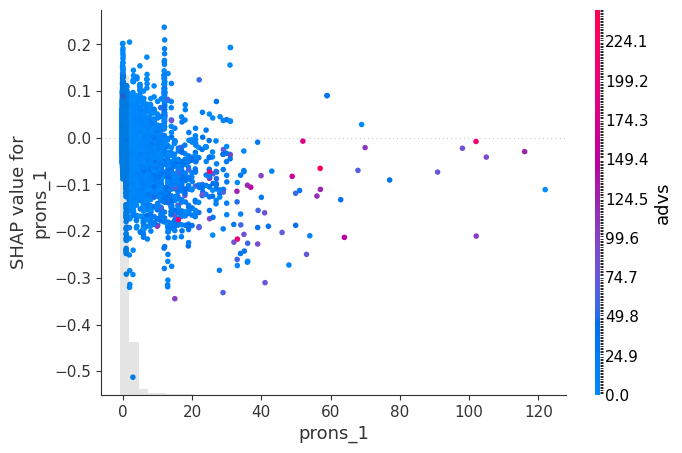

In [57]:
shap.plots.scatter(shap_values[:,"prons_1"], color=shap_values)

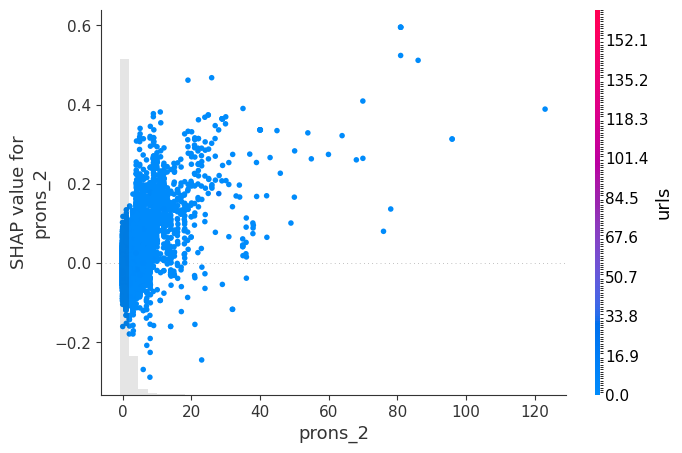

In [58]:
shap.plots.scatter(shap_values[:,"prons_2"], color=shap_values)

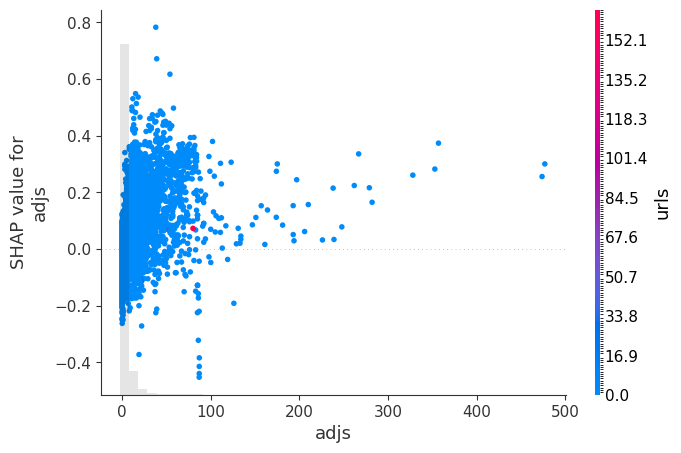

In [59]:
shap.plots.scatter(shap_values[:,"adjs"], color=shap_values)

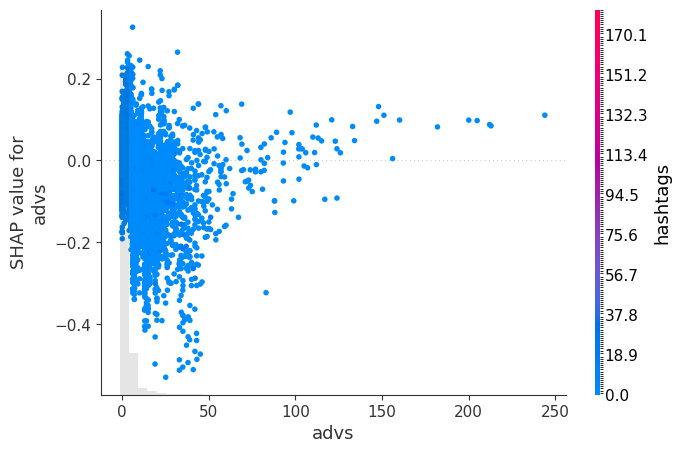

In [60]:
shap.plots.scatter(shap_values[:,"advs"], color=shap_values)

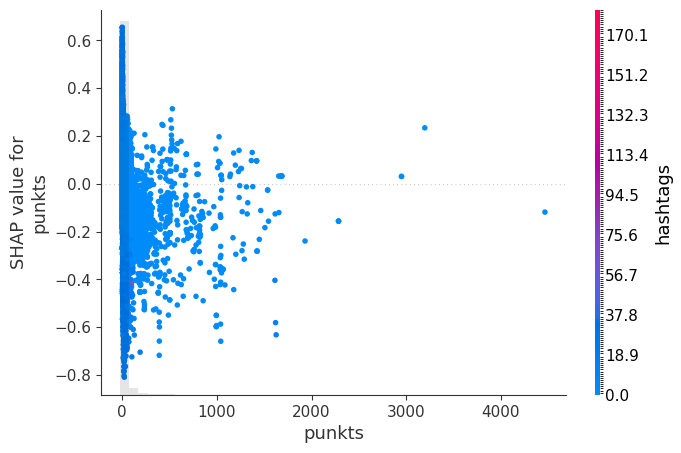

In [61]:
shap.plots.scatter(shap_values[:,"punkts"], color=shap_values)

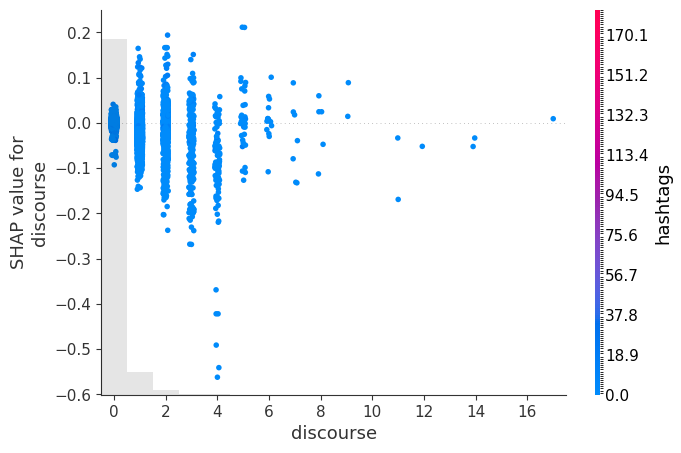

In [62]:
shap.plots.scatter(shap_values[:,"discourse"], color=shap_values)

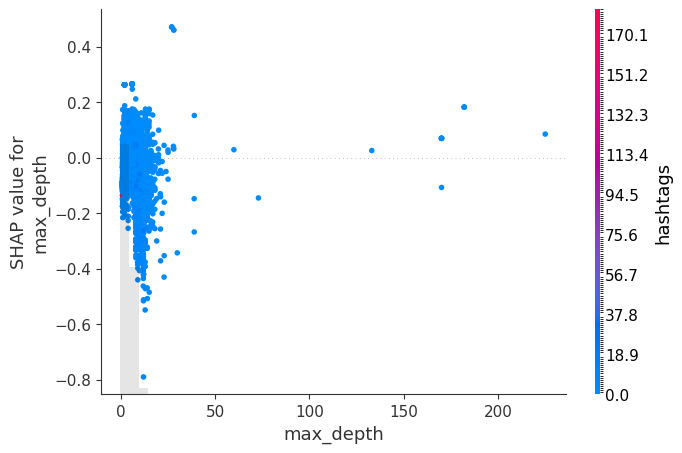

In [63]:
shap.plots.scatter(shap_values[:,"max_depth"], color=shap_values)

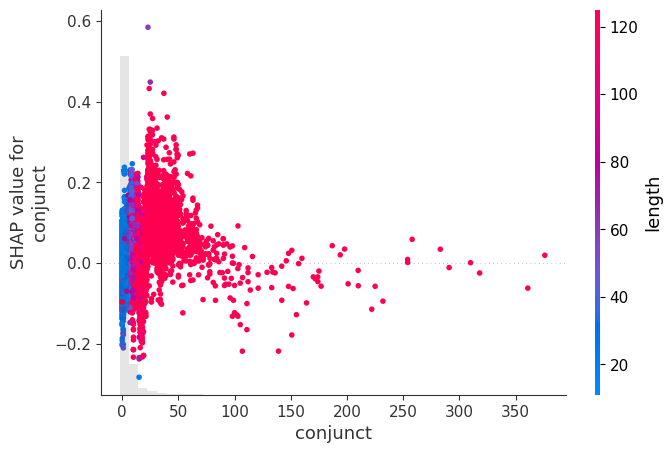

In [64]:
shap.plots.scatter(shap_values[:,"conjunct"], color=shap_values)

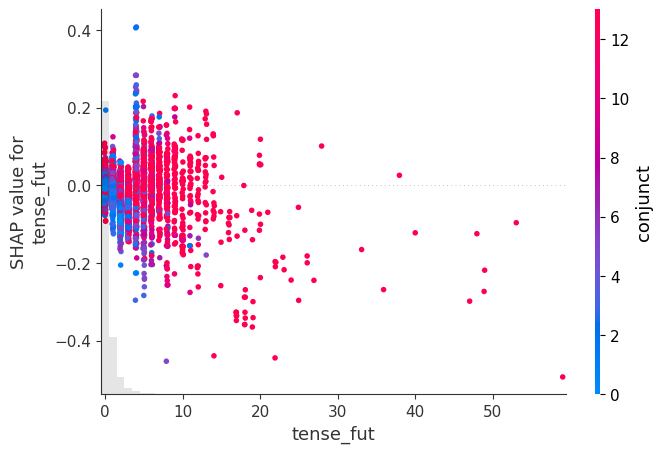

In [65]:
shap.plots.scatter(shap_values[:,"tense_fut"], color=shap_values)

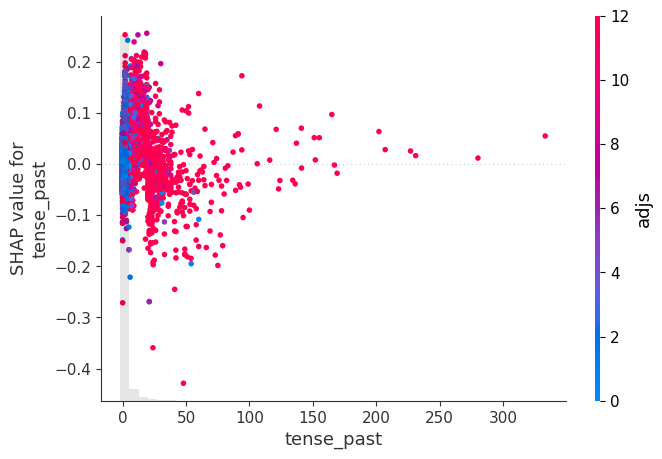

In [66]:
shap.plots.scatter(shap_values[:,"tense_past"], color=shap_values)

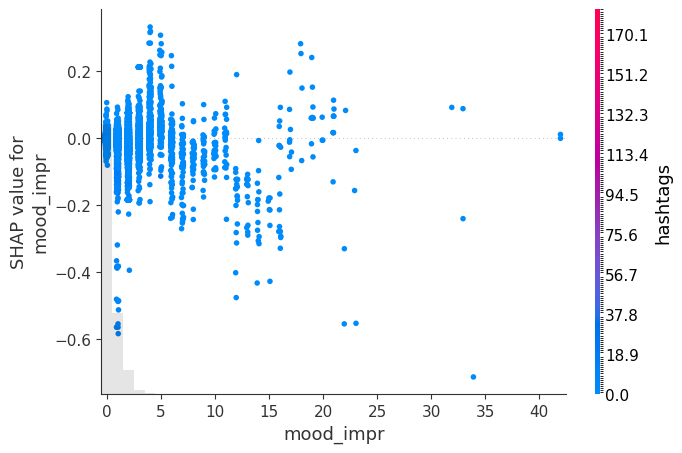

In [67]:
shap.plots.scatter(shap_values[:,"mood_impr"], color=shap_values)

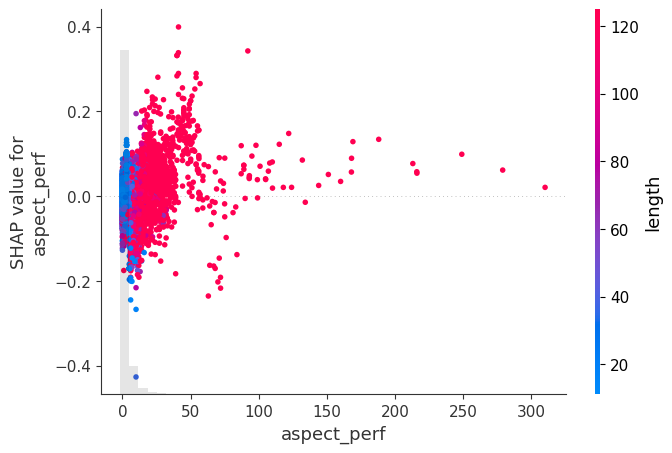

In [68]:
shap.plots.scatter(shap_values[:,"aspect_perf"], color=shap_values)

In [69]:
shap.initjs()
shap_values = explainer(X.head(100))
shap.plots.force(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


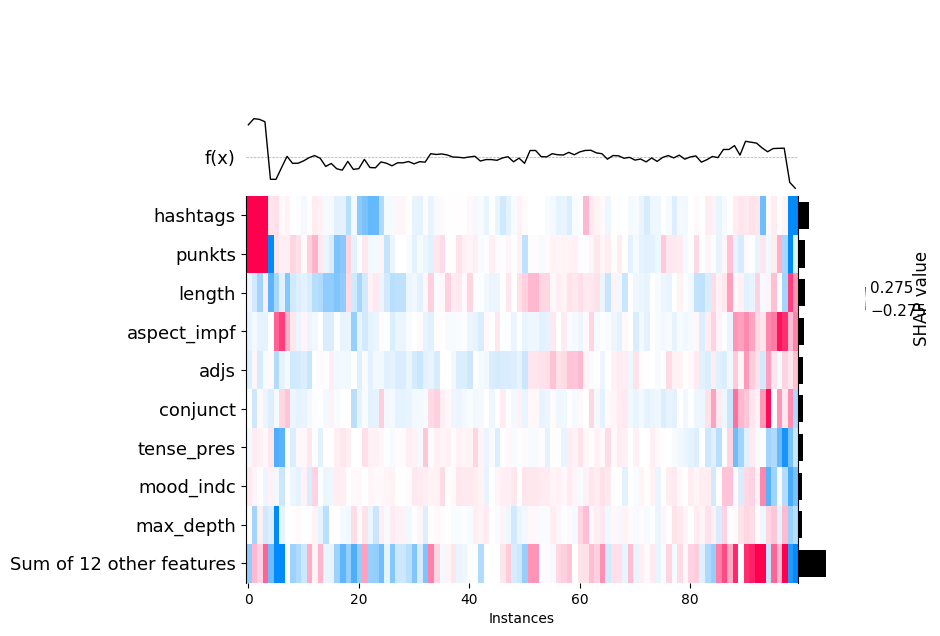

In [70]:
shap.plots.heatmap(shap_values)